In [3]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sessions = pd.read_csv("./sessions.csv")
X_test = pd.read_csv("./test_users.csv")
X_train = pd.read_csv("./train_users_2.csv")

In [4]:
X_train=X_train[X_train['date_account_created'].astype(str).str[:4].astype(int)>=2014]
X_test['country_destination'] = "NDF"
X_train=X_train[X_train['id'].isin(sessions['user_id'])][['id','country_destination']]
X_test=X_test[X_test['id'].isin(sessions['user_id'])][['id','country_destination']]
sessions.rename(columns={ sessions.columns[0]: "id" },inplace=True)
sessions=sessions[~sessions['id'].isnull()]

In [5]:
one_hot=pd.get_dummies(sessions['action'])
sessions=sessions.join(one_hot)
sessions=sessions[['id','show','index','search_results','personalize','search','ajax_refresh_subtotal','update','similar_listings','social_connections','reviews','active','similar_listings_v2','lookup','create','dashboard','header_userpic','collections','edit','campaigns','qt2']]
sessions=sessions.groupby('id').apply(lambda x: x.max())
sessions=pd.DataFrame(sessions)
sessions=sessions.drop(['id'],axis=1)
sessions=sessions.reset_index()


In [6]:
#print(X_train.shape)
X_train=pd.merge(X_train, sessions, how='left', on='id')
X_test=pd.merge(X_test, sessions, how='left', on='id')
print(X_train.shape)

(73815, 22)


In [7]:
X_train['target']=(X_train['country_destination']=='NDF').astype(int)
X_test['target']=(X_test['country_destination']=='NDF').astype(int)

In [8]:
ids_train=X_train[['id','country_destination','target']]
ids_test=X_test[['id','country_destination','target']]
X_train.drop(['id','country_destination'],axis=1,inplace=True)
X_test.drop(['id','country_destination'],axis=1,inplace=True)

In [18]:
X_train.to_pickle('./X_train.pkl')
X_test.to_pickle('./X_test.pkl')
ids_train.to_pickle('./ids_train.pkl')
ids_test.to_pickle('./ids_test.pkl')

In [4]:
from sklearn.model_selection import train_test_split
X_train=pd.read_pickle('./X_train.pkl')
y=X_train[['target']].as_matrix()
X=X_train.drop(['target'],axis=1).as_matrix()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
X_train=X_train.T
X_val=X_val.T
y_train=y_train.T
y_val=y_val.T

In [26]:
####Building tensor flow model

In [6]:
import tensorflow as tf
from tensorflow.python.framework import ops

In [7]:
import math
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [20, None])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.sigmoid(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

def forward_propagation_for_predict(X, parameters):   
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

In [19]:
#1. Creating placeholders
def create_placeholders(n_x,n_y):
    X=tf.placeholder(tf.float32,[n_x,None],name="X")
    Y=tf.placeholder(tf.float32,[n_y,None],name="Y")
    return X,Y
#2. Initialize parameters
def initialize_parameters():
    tf.set_random_seed(1)
    W1=tf.get_variable("W1",[25,20],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1=tf.get_variable("b1",[25,1],initializer=tf.zeros_initializer())
    W2=tf.get_variable("W2",[12,25],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2=tf.get_variable("b2",[12,1],initializer=tf.zeros_initializer())
    W3=tf.get_variable("W3",[1,12],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3=tf.get_variable("b3",[1,1],initializer=tf.zeros_initializer())
    parameters={"W1":W1,"b1":b1,"W2":W2,"b2":b2,"W3":W3,"b3":b3}
    return parameters
#3. Forward propagation
def forward_propagation(X,parameters,drop=False):
    W1=parameters['W1']
    b1=parameters['b1']
    W2=parameters['W2']
    b2=parameters['b2']
    W3=parameters['W3']
    b3=parameters['b3']
    Z1=tf.add(tf.matmul(W1,X),b1)
    A1=tf.nn.relu(Z1)
    if drop:
        A1 = tf.nn.dropout(A1, 0.5)
    Z2=tf.add(tf.matmul(W2,A1),b2)
    A2=tf.nn.relu(Z2)
    if drop:
        A2 = tf.nn.dropout(A2, 0.5)
    Z3=tf.add(tf.matmul(W3,A2),b3)
    return Z3
#4. Compute cost
def compute_cost(Z3,Y,lambda1,parameters):
    logits=tf.transpose(Z3)
    labels=tf.transpose(Y)
    cost=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=labels))
    reg = tf.nn.l2_loss(parameters['W1']) + tf.nn.l2_loss(parameters['W2']) + tf.nn.l2_loss(parameters['W3'])
    cost = tf.reduce_mean(cost + reg * lambda1)
    return cost

In [20]:
def model(X_train, y_train, X_val, y_val, start_learn_rate = 0.01,
          num_epochs = 200, minibatch_size = 32, lambda1=0.01, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_val -- training set, of shape (input size = 12288, number of training examples = 120)
    y_val -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters,drop=True)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y, lambda1, parameters)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    global_step=tf.Variable(0)
    learning_rate=tf.train.exponential_decay(start_learn_rate, global_step, 100000, 0.5, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost, global_step=global_step)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost,lr = sess.run([optimizer, cost,learning_rate], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                print ("learning_rate: %f" % (lr))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.round(tf.sigmoid(Z3)), Y)

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print("Train Accuracy:", accuracy.eval({X: X_train, Y: y_train}))
        print("Test Accuracy:", accuracy.eval({X: X_val, Y: y_val}))
        
        return parameters

Cost after epoch 0: 0.673544
learning_rate: 0.010000
Cost after epoch 100: 0.666217
learning_rate: 0.005000


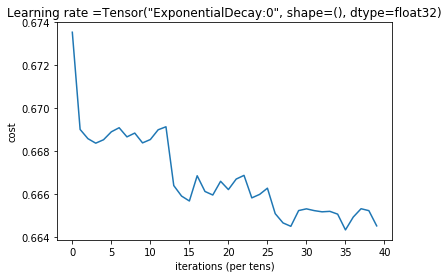

Parameters have been trained!
Train Accuracy: 0.6073277
Test Accuracy: 0.6132846


In [21]:
#Model training
parameters = model(X_train, y_train, X_val , y_val)

In [11]:
pred=predict(X_val,parameters)

In [ ]:
#Tunable: 
#parameters-layers,activation units
#hyperparameters-learning rate,beta1,beta2,epoch
#regularisation- L2 (lambda),Dropout, keep_prob
#Optimisation- Mini Batch size,Batch normalisation,optimiser